In [1]:
import pandas as pd
from datasets import load_dataset

goemotions = load_dataset("go_emotions")

train_data = goemotions["train"]
test_data = goemotions["test"]

print(train_data[0])

label_list = goemotions['train'].features['labels'].feature.names
print(label_list)

c:\Users\Musawer Afzal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since go_emotions couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'simplified' at C:\Users\Musawer Afzal\.cache\huggingface\datasets\go_emotions\simplified\0.0.0\add492243ff905527e67aeb8b80c082af02207c3 (last modified on Sat Apr 12 10:22:31 2025).


{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert Huggingface data to Dataframe
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes = list(range(len(label_list))))

# Apply one hot encodeing
y_train = mlb.fit_transform(train_df['labels'])
y_test = mlb.fit_transform(test_df['labels'])

# Final input texts
X_train = train_df['text'].tolist()
X_test = test_df['text'].tolist()

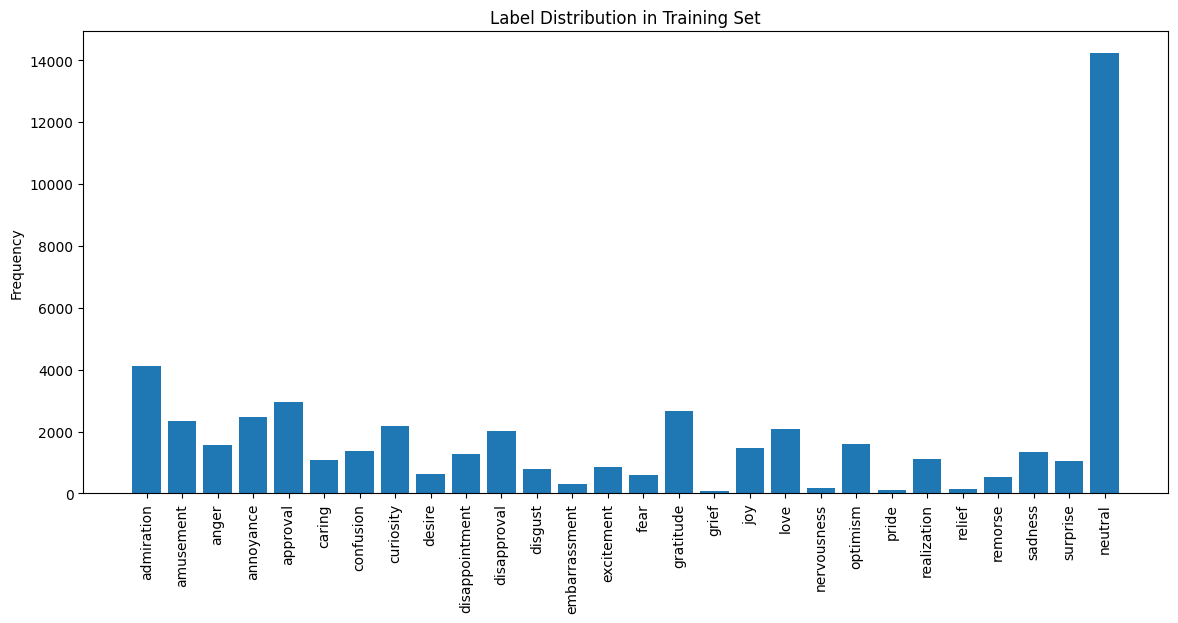

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Count frequency of each label across all samples
label_counts = np.sum(y_train, axis=0)

plt.figure(figsize=(14, 6))
plt.bar(label_list, label_counts)
plt.xticks(rotation=90)
plt.title("Label Distribution in Training Set")
plt.ylabel("Frequency")
plt.show()


In [4]:
from sklearn.utils import resample

# Combine features and labels for easier resampling
train_df['one_hot_labels'] = list(y_train)

# Explode DataFrame so we can sample rare labels
exploded_df = train_df.explode('labels')

# Find counts for each label
label_counts = exploded_df['labels'].value_counts()

# Set a minimum threshold (e.g., 2000 samples per label)
MIN_SAMPLES = 2000
oversampled_rows = []

for label in label_list:
    label_index = label_list.index(label)
    rows_with_label = train_df[train_df['labels'].apply(lambda x: label_index in x)]
    
    if len(rows_with_label) < MIN_SAMPLES:
        oversampled = resample(rows_with_label, 
                               replace=True,
                               n_samples=MIN_SAMPLES - len(rows_with_label),
                               random_state=42)
        oversampled_rows.append(oversampled)

# Combine original and oversampled data
if oversampled_rows:
    oversampled_df = pd.concat([train_df] + oversampled_rows, ignore_index=True)
else:
    oversampled_df = train_df

# Shuffle
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Final balanced inputs
X_train_balanced = oversampled_df['text'].tolist()
y_train_balanced = mlb.transform(oversampled_df['labels'])


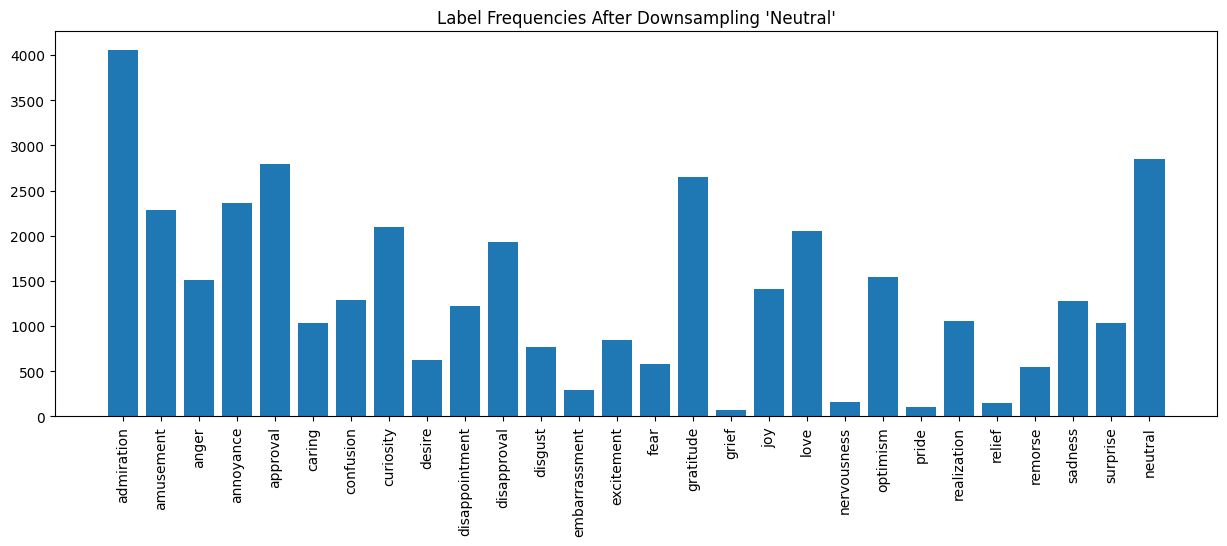

In [5]:
# Convert dataset to DataFrame
df = pd.DataFrame(train_data)

# Identify rows where 'neutral' (index 27) is in labels
neutral_index = label_list.index("neutral")
neutral_rows = df[df['labels'].apply(lambda x: neutral_index in x)]

# Keep only a fraction of the neutral examples (e.g., 20%)
neutral_sampled = neutral_rows.sample(frac=0.2, random_state=42)

# Get all non-neutral rows
non_neutral_rows = df[df['labels'].apply(lambda x: neutral_index not in x)]

# Combine and shuffle the balanced DataFrame
balanced_df = pd.concat([neutral_sampled, non_neutral_rows]).sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Check class frequencies
from collections import Counter
from itertools import chain

all_labels = list(chain.from_iterable(balanced_df["labels"]))
label_counts = Counter(all_labels)

# Visualize label distribution again
import matplotlib.pyplot as plt

label_freq = [label_counts.get(i, 0) for i in range(len(label_list))]

plt.figure(figsize=(15,5))
plt.bar(label_list, label_freq)
plt.xticks(rotation=90)
plt.title("Label Frequencies After Downsampling 'Neutral'")
plt.show()


In [6]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sample function to tokenize text
def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings, labels


In [7]:
import torch
from torch.utils.data import Dataset

class GoEmotionsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['labels'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        # Create multi-hot encoding for labels
        label_vector = torch.zeros(len(label_list))
        label_vector[self.labels[idx]] = 1

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': label_vector
        }


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the balanced dataset
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = GoEmotionsDataset(train_df, tokenizer)
val_dataset = GoEmotionsDataset(val_df, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [9]:
import torch.nn as nn
from transformers import BertModel

class BertForMultiLabel(nn.Module):
    def __init__(self, num_labels):
        super(BertForMultiLabel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return torch.sigmoid(logits)  # sigmoid for multi-label


In [10]:
import torch
from torch.optim import AdamW

# Number of labels in GoEmotions
num_labels = len(label_list)

# Initialize model
model = BertForMultiLabel(num_labels=num_labels)
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

train(model)


In [12]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    return total_loss / len(loader)


In [ ]:
from torch.utils.data import DataLoader, random_split

# Assuming 'dataset' is your full GoEmotionsDataset object
train_size = int(0.8 * len(goemotions))
val_size = len(goemotions) - train_size
train_dataset, val_dataset = random_split(goemotions, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Set number of epochs
epochs = 3

for epoch in range(epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{epochs}")
    train_loss = train(model, train_dataloader)
    val_loss = evaluate(model, val_dataloader)
    print(f"✅ Training Loss: {train_loss:.4f} | 🔍 Validation Loss: {val_loss:.4f}")